# 제주도 버스승차 인원 예측
- ## data 415423 rows × 21 columns
### train columns

#### 날짜 / 노선 / 정류장별로 row를 구성
- `id` : 해당 데이터에서의 고유한 id
- `data` : 날짜
- `bus_route_id` : 노선 ID
- `in_out` : 시내버스, 시외버스 구분
- `station_code` : 해당 승하차 정류소의 id
- `station_name` : 해당 승하차 정류소의 이름
- `latitude` : 해당 버스정류장의 위도
- `longitude` : 해당 버스정류장의 경도
- `rideX` : X시부터 1시간 동안 승차한 인원 수 (start~end)
- `offX` : X시부터 1시간 동안 하차한 인원 수 (start~end)
- `ride18` : 18시부터 20시까지 승차한 인원 수

In [1]:
# 추가되는 패키지는 여기에서 import 해주세요
import warnings
warnings.filterwarnings('ignore')
import missingno
import pandas as pd
import numpy as np
import datetime
import statsmodels.api as sm
import folium
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from sklearn.base import BaseEstimator, RegressorMixin
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from itertools import count
import geopy.distance
pd.options.mode.chained_assignment = None 

pd.set_option('display.max_columns', 500)

# matplotlib 설정
mpl.use('Agg')
mpl.rcParams['axes.unicode_minus'] = False
# seaborn 설정
sns.set()
sns.set_style("whitegrid")
sns.set_color_codes()

from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)



In [2]:
# 데이터 load
train = pd.read_csv('train.csv',date_parser='date')
train.tail()
# 분석을 위해 컬럼명 수정
train.rename(columns={'6~7_ride': 'ride6', '7~8_ride': 'ride7', '8~9_ride': 'ride8',\
                      '9~10_ride': 'ride9', '10~11_ride': 'ride10', '11~12_ride': 'ride11', 
                      '6~7_takeoff': 'off6', '7~8_takeoff': 'off7', '8~9_takeoff': 'off8', \
                      '9~10_takeoff': 'off9', '10~11_takeoff': 'off10', '11~12_takeoff': 'off11',\
                      '18~20_ride': 'ride18'},inplace=True)
train

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,ride6,ride7,ride8,ride9,ride10,ride11,off6,off7,off8,off9,off10,off11,ride18
0,0,2019-09-01,4270000,시외,344,제주썬호텔,33.48990,126.49373,0.0,1.0,2.0,5.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2019-09-01,4270000,시외,357,한라병원,33.48944,126.48508,1.0,4.0,4.0,2.0,5.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
2,2,2019-09-01,4270000,시외,432,정존마을,33.48181,126.47352,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
3,3,2019-09-01,4270000,시내,1579,제주국제공항(600번),33.50577,126.49252,0.0,17.0,6.0,26.0,14.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,53.0
4,4,2019-09-01,4270000,시내,1646,중문관광단지입구,33.25579,126.41260,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5,5,2019-09-01,4270000,시내,1648,예래입구,33.25862,126.40442,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
6,6,2019-09-01,4270000,시외,1660,제주국제컨벤션센터중문대포해안주상절리대,33.24309,126.42472,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,3.0
7,7,2019-09-01,4270000,시외,1666,창천리,33.26598,126.37082,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
8,8,2019-09-01,4270000,시외,1726,강정농협,33.23603,126.47827,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0
9,9,2019-09-01,4270000,시내,2008,서귀포항,33.23977,126.56450,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 415423 entries, 0 to 415422
Data columns (total 21 columns):
id              415423 non-null int64
date            415423 non-null object
bus_route_id    415423 non-null int64
in_out          415423 non-null object
station_code    415423 non-null int64
station_name    415423 non-null object
latitude        415423 non-null float64
longitude       415423 non-null float64
ride6           415423 non-null float64
ride7           415423 non-null float64
ride8           415423 non-null float64
ride9           415423 non-null float64
ride10          415423 non-null float64
ride11          415423 non-null float64
off6            415423 non-null float64
off7            415423 non-null float64
off8            415423 non-null float64
off9            415423 non-null float64
off10           415423 non-null float64
off11           415423 non-null float64
ride18          415423 non-null float64
dtypes: float64(15), int64(3), object(3)
memory usage: 66.

In [4]:
train.describe()

,id,bus_route_id,station_code,latitude,longitude,ride6,ride7,ride8,ride9,ride10,ride11,off6,off7,off8,off9,off10,off11,ride18
count,415423.000000,4.154230e+05,4.154230e+05,415423.000000,415423.000000,415423.000000,415423.000000,415423.000000,415423.000000,415423.000000,415423.000000,415423.000000,415423.000000,415423.000000,415423.000000,415423.000000,415423.000000,415423.000000
mean,207711.000000,2.691935e+07,4.209311e+04,33.420375,126.533574,0.305893,0.829699,0.815350,0.642475,0.599618,0.579393,0.112870,0.344870,0.516481,0.430922,0.408001,0.402874,1.242095
std,119922.434776,3.924652e+06,4.971504e+05,0.107996,0.140986,1.109766,2.255116,2.317561,1.959844,1.885941,1.942137,0.597714,1.279179,1.658850,1.485124,1.412839,1.446080,4.722287
min,0.000000,4.270000e+06,1.000000e+00,33.208350,126.165040,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,103855.500000,2.346000e+07,3.200000e+02,33.291080,126.475780,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,207711.000000,2.803000e+07,1.130000e+03,33.478850,126.529770,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,311566.500000,3.003000e+07,2.226000e+03,33.500020,126.575890,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,415422.000000,3.282000e+07,6.115101e+06,33.963640,126.965670,85.000000,94.000000,136.000000,78.000000,124.000000,99.000000,45.000000,66.000000,59.000000,65.000000,52.000000,81.000000,272.000000


In [5]:
for i in train.columns:
    print('{}의 갯수는{} '.format(i,len(train[i].unique())))

id의 갯수는415423 
date의 갯수는30 
bus_route_id의 갯수는613 
in_out의 갯수는2 
station_code의 갯수는3563 
station_name의 갯수는1961 
latitude의 갯수는3278 
longitude의 갯수는3446 
ride6의 갯수는47 
ride7의 갯수는80 
ride8의 갯수는78 
ride9의 갯수는66 
ride10의 갯수는66 
ride11의 갯수는69 
off6의 갯수는35 
off7의 갯수는51 
off8의 갯수는53 
off9의 갯수는46 
off10의 갯수는47 
off11의 갯수는55 
ride18의 갯수는170 


In [6]:
train.query('ride18 == 272')

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,ride6,ride7,ride8,ride9,ride10,ride11,off6,off7,off8,off9,off10,off11,ride18
190528,190528,2019-09-15,23620000,시내,638,제주국제공항(구제주방면),33.50661,126.49345,3.0,31.0,32.0,49.0,36.0,41.0,6.0,14.0,20.0,11.0,8.0,8.0,272.0


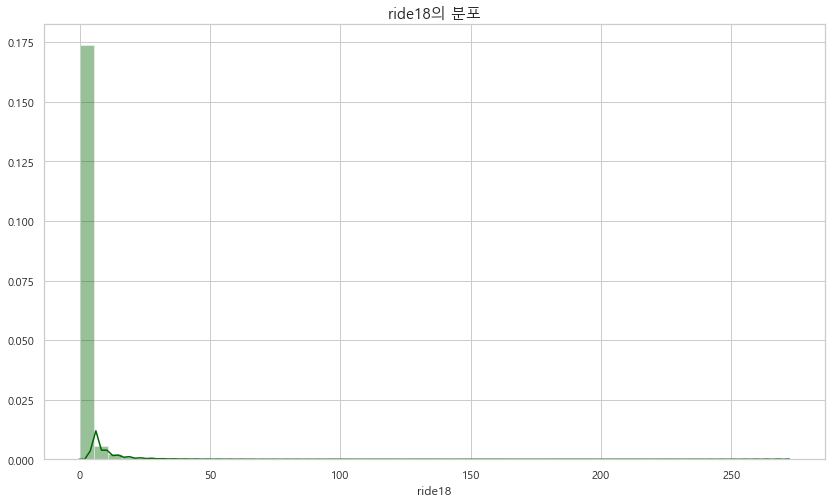

In [7]:
#max(ride18): 제주국제공항 272명
plt.figure(figsize = (14,8))
sns.distplot(train.ride18, color ='darkgreen')
plt.title('ride18의 분포', fontsize = 15)
plt.show()

In [8]:
terribles = train.query('ride18 >= 50')
list(terribles.query('ride18>=80').station_name.unique())

['제주고등학교/중흥S클래스',
 '은남동',
 '제주국제공항(신제주방면)',
 '제주국제공항(구제주방면)',
 '제주대학교',
 '제주시청(광양방면)',
 '제주한라대학교',
 '제주관광대학',
 '제주한라대학교(종점)',
 '제주시청(아라방면)',
 '회천입구',
 '중앙로터리(동)',
 '산천단한국폴리텍대학',
 '중앙로(국민은행)',
 '제원아파트',
 '제주국제공항(600번)',
 '제주국제공항(대정,화순,일주서로)',
 '큰동네',
 '시외버스출발지(가상정류소)',
 '수산리사무소앞',
 '제주대학교병원',
 '한라수목원',
 '제주버스터미널']

### 9월 한달 간 50명 18시~ 20시 동안 한 노선에 50명 이상이 탑승한 정류장

In [9]:
map_osm = folium.Map(location=[33.48944, 126.48508], zoom_start= 11)
for i in terribles.index:
    folium.CircleMarker([terribles.loc[i,'latitude'], terribles.loc[i,'longitude']], radius= terribles.loc[i,'ride18']/20 ,color='red',fill_color='#red', popup= terribles.loc[i,'bus_route_id']).add_to(map_osm)
map_osm

In [10]:
# 시작 날짜와, 끝 날짜 확인
print(train['date'].min())
print(train['date'].max())
# date 타입 변경
train['date'] = train['date'].astype('datetime64')
# 9월 1일 ~ 9월 30일 데이터이니까, day만 따로 가져옴
train['date_day'] = train['date'].dt.day
# 월(0) ~ 일(6) 데이터로 변환
train['date_dayofweek'] = train['date'].dt.dayofweek
train['date_dayofname']= train['date'].dt.weekday_name
train[['date','date_dayofweek','date_day','date_dayofname']]

# 추석 추가 컬럼명 : 'thanksgiving_Day'
train['thanksgiving_Day'] = 0
train.loc[train['date'] == '2019-09-14', 'thanksgiving_Day'] = 1
train.loc[train['date'] == '2019-09-13', 'thanksgiving_Day'] = 1
train.loc[train['date'] == '2019-09-12', 'thanksgiving_Day'] = 1
print(train['thanksgiving_Day'].sum())
# 제대로 바뀌었는지 확인
train[train['date'] == '2019-09-14'].count()[0] + \
train[train['date'] == '2019-09-12'].count()[0] + \
train[train['date'] == '2019-09-13'].count()[0]

2019-09-01
2019-09-30
30719


30719

### 어떤 변수들을 고려해야 할까?
- 2019년 9월 1일(일요일) ~ 2019년 9월 30일(월요일)
- 2019년 9월 12일~14일 추석 공휴일, 15일은 일요일 : 공휴일과 주말을 고려하자
- 2918년 9월 6일 태풍 : 날씨도 고려하자

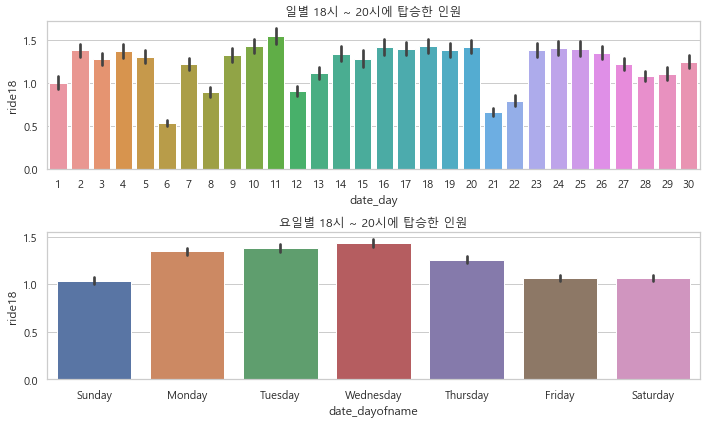

In [11]:
# 일별, 요일별 탑승한 인원 그래프
plt.figure(figsize=(10, 6))
plt.subplot(211)
plt.title('일별 18시 ~ 20시에 탑승한 인원')
sns.barplot(x='date_day', y='ride18', data=train)

plt.subplot(212)
plt.title('요일별 18시 ~ 20시에 탑승한 인원')
sns.barplot(x='date_dayofname', y='ride18', data=train)
plt.tight_layout()
plt.show()

### 승하차 분석

In [12]:
values = ['ride6', 'ride7', 'ride8',
          'ride9', 'ride10', 'ride11', 'off6', 'off7', 'off8', 'off9', 'off10',
          'off11', 'ride18']
values_ride = ['ride6', 'ride7', 'ride8',
               'ride9', 'ride10', 'ride11']
values_off = ['off6', 'off7', 'off8', 'off9', 'off10',
              'off11']

table_all = pd.pivot_table(train, index=['station_name','station_code'], aggfunc=sum, values=values)
table_ride = pd.pivot_table(train, index=['station_name','station_code'], aggfunc=sum, values=values_ride)
table_off = pd.pivot_table(train, index=['station_name','station_code'], aggfunc=sum, values=values_off)
table_ride18 = pd.pivot_table(train, index=['station_name','station_code'], aggfunc= sum, values='ride18')

In [13]:
table_ride18.sort_values('ride18', ascending = False).head(20)

ride18
station_name     station_code         
제주대학교            201           17152.0
제주시청(광양방면)       3271          14206.0
제주시청(아라방면)       3270          10375.0
제주국제공항(구제주방면)    638            9435.0
제주국제공항(신제주방면)    1355           8216.0
한라병원             358            7614.0
                 357            6330.0
제주버스터미널          149            5907.0
제주시외버스터미널        1564           5555.0
제주도청신제주로터리       320            5452.0
제주중앙여자고등학교(광양방면) 3277           5349.0
시외버스출발지(가상정류소)   1565           4971.0
동문로터리(동문시장)      279            4905.0
                 280            4662.0
제주고등학교/중흥S클래스    447            4507.0
중앙로(국민은행)        284            4479.0
중앙로터리(동)         1784           4398.0
노형오거리            360            4322.0
제주도청신제주로터리       321            3946.0
제주지방법원(광양방면)     3275           3818.0

### 상관관계
- 오전에 많이 타고 많이 내리는 곳 = 18~20시에 많이 타는 곳

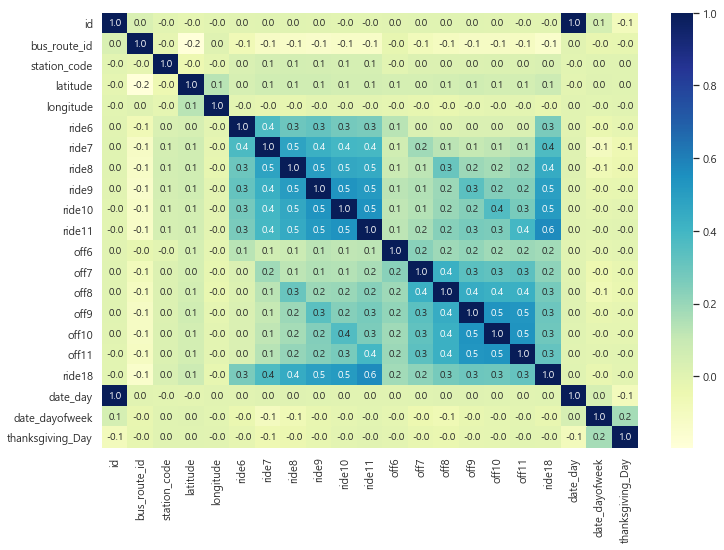

In [14]:
plt.figure(figsize=(12, 8))
sns.heatmap(train.corr(), annot=True, cmap= 'YlGnBu', fmt='.1f')
plt.show()

### 시행착오
- 버스 정류장 3563개, 버스 노선 613개를 모두 카테고리화 할 수 없다 (41만행)
- 둘을 제외하고 분석을 실행하니 R^2가 너무 낮게 나왔다. (0.44) 이를 높이기 위해
    - 어떻게든 버스 정류장의 위치 정보를 나타내려 는 시도
        - 시도1: 제주시, 서귀포시에서의 거리를 구한다
        - 시도2: 주소를 기반으로 범주화한다
    - 외부 데이터를 결합해 추가 feature (날씨 데이터) 생성

In [15]:
cols = list(train.columns)
cate = ['in_out','date_dayofweek','station_code','thanksgiving_Day']
unnecessary = ['id','date','bus_route_id','station_name','latitude','longitude','date_day','date_dayofname','ride18']
[cols.remove(cat) for cat in cate]
[cols.remove(un) for un in unnecessary]
var = cols
var_scale = ["scale({})".format(name) for name in var]
var_scale

['scale(ride6)',
 'scale(ride7)',
 'scale(ride8)',
 'scale(ride9)',
 'scale(ride10)',
 'scale(ride11)',
 'scale(off6)',
 'scale(off7)',
 'scale(off8)',
 'scale(off9)',
 'scale(off10)',
 'scale(off11)']

In [16]:
model = sm.OLS.from_formula(
    'ride18 ~ C(station_code) + C(date_dayofweek) + '+'+'.join(var_scale), data=train)
result = model.fit()
print(result.summary())

MemoryError: 

In [17]:
model = sm.OLS.from_formula(
    'ride18 ~ C(thanksgiving_Day) + C(date_dayofweek) + '+'+'.join(var_scale), data=train)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                 ride18   R-squared:                       0.443
Model:                            OLS   Adj. R-squared:                  0.443
Method:                 Least Squares   F-statistic:                 1.739e+04
Date:                Fri, 03 Apr 2020   Prob (F-statistic):               0.00
Time:                        18:50:15   Log-Likelihood:            -1.1128e+06
No. Observations:              415423   AIC:                         2.226e+06
Df Residuals:                  415403   BIC:                         2.226e+06
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [18]:
coords_jejusi = (33.500770, 126.522761) #제주시의 위도 경도
coords_seoquipo = (33.259429, 126.558217) #서귀포시의 위도 경도
train['dis_jejusi'] = [geopy.distance.vincenty((train['latitude'].iloc[i],train['longitude'].iloc[i]), coords_jejusi).km for i in range(len(train))]
train['dis_seoquipo'] = [geopy.distance.vincenty((train['latitude'].iloc[i],train['longitude'].iloc[i]), coords_seoquipo).km for i in range(len(train))]

In [19]:
train.head()

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,ride6,ride7,ride8,ride9,ride10,ride11,off6,off7,off8,off9,off10,off11,ride18,date_day,date_dayofweek,date_dayofname,thanksgiving_Day,dis_jejusi,dis_seoquipo
0,0,2019-09-01,4270000,시외,344,제주썬호텔,33.48990,126.49373,0.0,1.0,2.0,5.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,6,Sunday,0,2.954920,26.256744
1,1,2019-09-01,4270000,시외,357,한라병원,33.48944,126.48508,1.0,4.0,4.0,2.0,5.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,1,6,Sunday,0,3.720275,26.403025
2,2,2019-09-01,4270000,시외,432,정존마을,33.48181,126.47352,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1,6,Sunday,0,5.036124,25.893305
3,3,2019-09-01,4270000,시내,1579,제주국제공항(600번),33.50577,126.49252,0.0,17.0,6.0,26.0,14.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,53.0,1,6,Sunday,0,2.864166,27.997494
4,4,2019-09-01,4270000,시내,1646,중문관광단지입구,33.25579,126.41260,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,6,Sunday,0,29.040353,13.574693


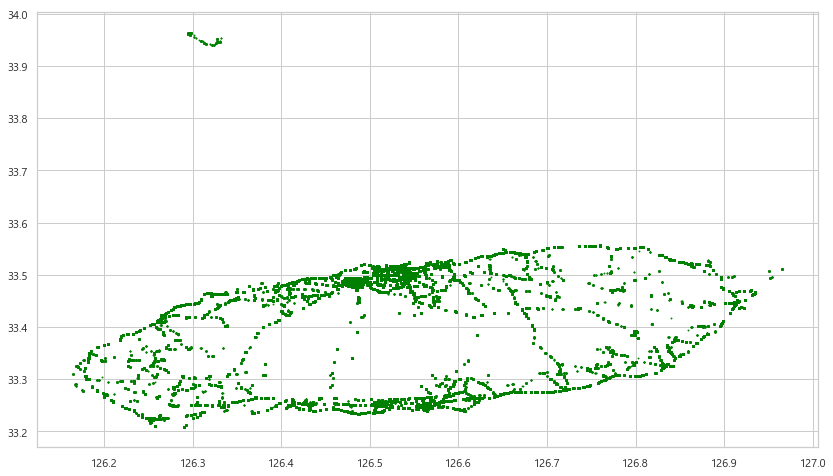

In [20]:
# 위도 경도 확인
plt.figure(figsize = (14,8))
plt.scatter('longitude','latitude',data=train,  s = 0.8, edgecolor = 'green')
plt.show()

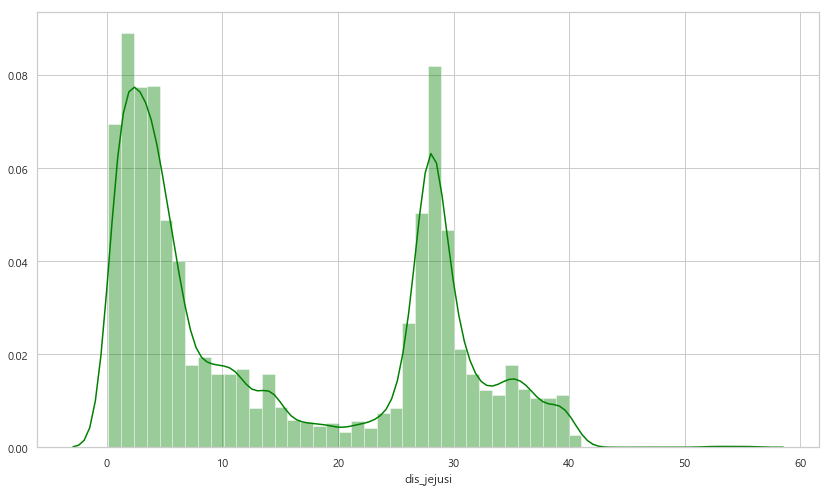

In [21]:
plt.figure(figsize = (14,8))
sns.distplot(train.dis_jejusi, color = 'green')
plt.show()

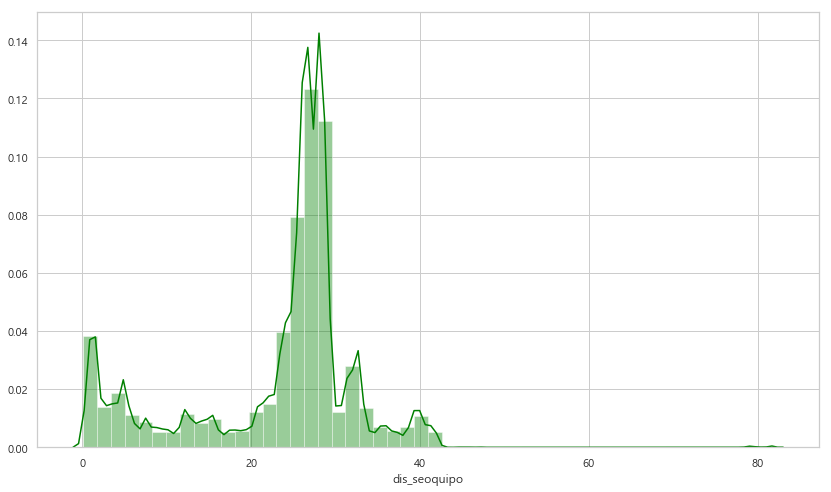

In [22]:
plt.figure(figsize = (14,8))
sns.distplot(train.dis_seoquipo, color = 'green')
plt.show()

### 도심에서의 거리와 퇴근시간 승차
- 실수형으로 도심에서의 거리를 나타냈지만, 거리와 ride18의 관계가 선형 관계가 아니었다.

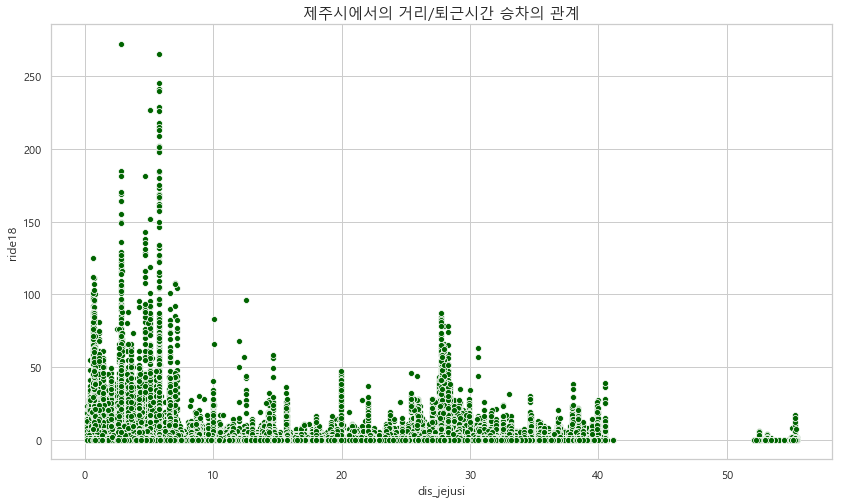

In [23]:
plt.figure(figsize = (14,8))
sns.scatterplot(train.dis_jejusi, train.ride18, color = 'darkgreen')
plt.title('제주시에서의 거리/퇴근시간 승차의 관계', fontsize = 15)
plt.show()

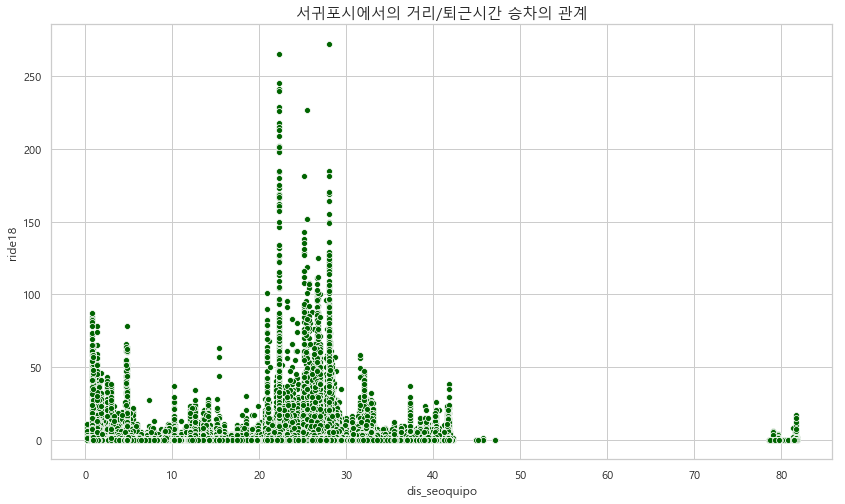

In [24]:
plt.figure(figsize = (14,8))
sns.scatterplot(train.dis_seoquipo, train.ride18, color = 'darkgreen')
plt.title('서귀포시에서의 거리/퇴근시간 승차의 관계', fontsize = 15)
plt.show()

### 주소 기반 정류장 범주화

In [25]:
jeju_addr = pd.read_csv('jeju_addr.csv')
jeju_addr.tail()

,station_code,city,addr,road_addr
3559,6115052.0,제주시,우도면,우도해안길
3560,6115059.0,제주시,우도면,우목길
3561,6115100.0,서귀포시,법환동,일주동로
3562,6115101.0,서귀포시,법환동,일주동로
3563,NaN,NaN,NaN,NaN


In [26]:
train = train.merge(jeju_addr, left_on ='station_code' , right_on = 'station_code')
train.tail()

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,ride6,ride7,ride8,ride9,ride10,ride11,off6,off7,off8,off9,off10,off11,ride18,date_day,date_dayofweek,date_dayofname,thanksgiving_Day,dis_jejusi,dis_seoquipo,city,addr,road_addr
415418,374291,2019-09-28,20010000,시외,6115044,대서리,33.96252,126.29429,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28,5,Saturday,0,55.420244,81.739546,제주시,추자면,추자로
415419,393524,2019-09-29,27880000,시내,1368,저지리알못,33.33595,126.26332,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,29,6,Sunday,0,30.273053,28.747464,제주시,한경면,용금로
415420,397921,2019-09-29,31580000,시내,3576,어썸브리즈,33.25899,126.27554,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,29,6,Sunday,0,35.331147,26.339595,서귀포시,대정읍,보성구억로
415421,400433,2019-09-30,22210000,시내,1585,셰프라인월드,33.43489,126.73242,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30,0,Monday,0,20.813985,25.331042,제주시,구좌읍,비자림로
415422,406662,2019-09-30,27180000,시내,3552,행원교차로,33.54574,126.80370,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,30,0,Monday,0,26.570918,39.113855,제주시,구좌읍,일주동로


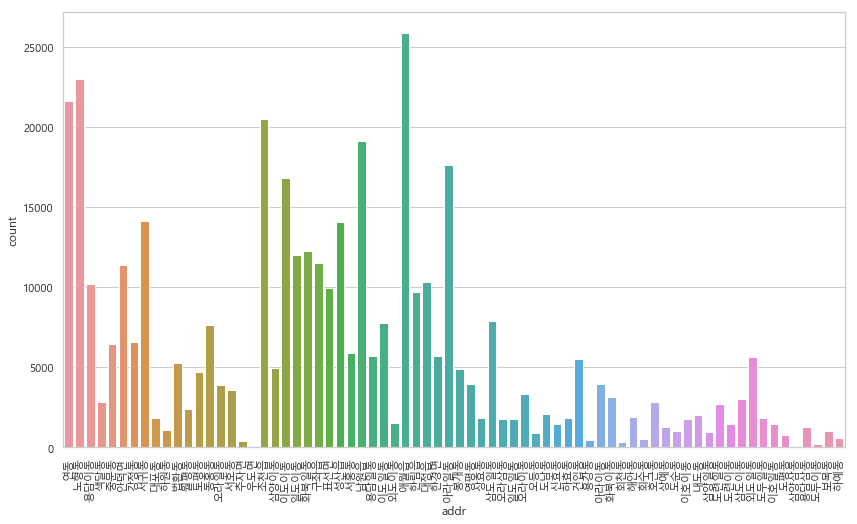

In [27]:
plt.figure(figsize = (14,8))
sns.countplot(train.addr)
plt.xticks(rotation = 90)
plt.show()

### 하나의 모델을 포기하자
- 41만행 x 3563개+의 카테고리 변수를 한 모델로 돌리기엔 메모리가 부족
- 작은 모델들을 여러개 만들면 `정류장 코드`를 사용할 수 있지 않을까?
- `정류장 코드`를 대신하기 위해 만든 `제주시에서의거리(km)`, `서귀포시에서의거리(km)`, `주소카테고리` 를 사용하지 않아도 된다

In [28]:
print('정류장 코드의 개수는 {}개, 노선 번호는 {}개'.format(len(train.station_code.unique()),len(train.bus_route_id.unique())))

정류장 코드의 개수는 3563개, 노선 번호는 613개


In [29]:
def ols(data, var, cate):

    columns = data.columns
    df_train = pd.DataFrame(columns=columns)
    df_train['yhat'] = 0

    # 모델 학습
    for i in data['station_code'].unique():
        sample = data[data['station_code'] == i]

        model = sm.OLS.from_formula(
            'ride18  ~ ' + '+'.join(var) + '+'.join('+') + '+'.join(cate_c), data=sample)
        result = model.fit()
        sample['yhat'] = result.predict()
        df1 = pd.DataFrame(sample, columns=df_train.columns)
        df_train = pd.concat([df_train, df1])

    df_train.loc[df_train['yhat'] < 0, 'yhat'] = 0
    df_train['yhat'] = round(df_train['yhat'])
    df_train['residual'] = df_train['ride18'] - df_train['yhat']
    df_train['explained'] = df_train['yhat'] - df_train['yhat'].mean()
    df_train['total'] = df_train['ride18'] - df_train['ride18'].mean()
    return df_train

In [30]:
np.random.seed(10)
train_test = train.copy()
test_frame = pd.DataFrame(columns=train_test.columns)
for i in np.random.choice(train_test['station_code'].unique(), 100, replace=False):
    df1 = train_test[train_test['station_code'] == i]
    test_frame = pd.concat([test_frame, df1])

In [31]:
test_frame.shape

(11514, 30)

In [32]:
import time
var = ['ride6', 'ride7', 'ride8', 'ride9', 'ride10', 'ride11',
       'off6', 'off7', 'off8', 'off9', 'off10', 'off11']
cate = ['in_out', 'thanksgiving_Day', 'date_day', 'date_dayofweek','bus_route_id']
var_scale = ["scale({})".format(name) for name in var]
cate_c = ["C({})".format(name) for name in cate]

# 함수 사용
start= time.time()
df = ols(test_frame, var, cate)
end = time.time()
print(end-start)

9.514743566513062


In [33]:
ess = (df['explained'] ** 2).sum()
rss = (df['residual'] ** 2).sum()
tss = (df['total'] ** 2).sum()
print('ESS는 {} 입니다.'.format(ess))
print('RSS는 {} 입니다.'.format(rss))
print('TSS는 {} 입니다.'.format(tss))
print('결정계수는 {}, {} 입니다.'.format(1-rss/tss,ess/tss))

ESS는 107218.15363904813 입니다.
RSS는 32864.0 입니다.
TSS는 141625.43694632623 입니다.
결정계수는 0.7679512896228173, 0.7570543537294229 입니다.


In [ ]:
#y랑 y_predict

### ?. 해결되지 않은 문제들